# **Custering and Reference Extraction**

Authors: 
- Victor Tang

Reviewed/Edited by:
- Marcos Kavlin
- Dr. Andrew Dean

### Purpose

This notebook is the fourth in the Wetland Function Assessment Tutorial.
The goal of this notebook is to show you, the user, how to embed your data into 2 dimensions using PCA and T-SNE, and then conduct a cluster analysis on it using HDBSCAN.
This type of exploratory analysis can help a user better understand the landsape they are analyzing. The steps followed in this tutorial will show the user how to split the time series data, into statistically significant clusters, and the visualize the time series of each one. This allows the user to parse out and identify the different typologies that may be taking place in their landscape.

Additionally, once we identify the clusters in our data, we can calculate the mean time series within each cluster in order to obtain the reference time series for each typology. This will then be used in the following notebook for our Dynamic Time-Warping.


### Workflow

1. Import required packages.
2. Data pre-processing.
3. Load time series data from previous notebook.
4. Embed our data using PCA and T-SNE.
5. Conduct a cluster analysis on the data using HDBSCAN.
6. Extract average time series per cluster.

### Notes

The composites that were used to run this notebook are placeholders used to demonstrate this workflow. The data required to run the steps demonstrated in this notebook are 10 day Sentinel 1 median composites. In this tutorial the images were produced for the year 2022. The images were grouped into 10 day composites as that was most conducive to a complete year-long time series, while still removing speckle and noise. They were all stored in a folder for the year 2022.

The landscape units used in this tutorial were the output from the previous notebook.

## 1. Import required packages

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

from distinctipy import distinctipy

plt.style.use('fivethirtyeight')

## 2. Load Time Series

We start by loading the time series data from the previous notebook.

***Note: Example data is provided for this notebook so feel free to follow along with it if you'd like.***

In [14]:
df_vh = pd.read_csv('data/vh_2022.csv', index_col=0, header=0)
df_vh.shape

(7792, 36)

## 3. Data pre-processing

**Note:** T-SNE is not able to handle time series with NaN's included in it.

This leaves us with two options:

1. Fill data gaps using interpolation (in the cell below we use linear)
2. Drop the incomplete time series

Feel free to experiment with both when using this workflow, and comment out the line that doesn't best suit your data.

In [25]:
# fill small gaps using linear interpolation
df_vh = df_vh.interpolate(method='linear', axis=1, limit=1)

# drop incomplete time series
df_vh = df_vh.dropna(how='any', axis=0)

In [26]:
data = df_vh.values

pid = df_vh.index.values

## 4. Embedding

### 4.1 Embedding with PCA

PCA reduces the dimensionality while preserving the overall information in the dataset.
In so doing the user will gain a greater understanding of the variation between the different samples in the time series data.
The cell below displays the variance explained by each principal component as a list. In this example we see that the first principal component
explains 64.9% of the variance in the dataset, the next princiapl component explains 8.8% of variance in the dataset, etc.

This method condenses the information and help us determine the most important principal components to then feed into the T-SNE algorithm.

***If you would like to learn more about PCA follow this link: https://medium.com/analytics-vidhya/pca-a-linear-transformation-f8aacd4eb007***

In [27]:
n_dim = data.shape[1]

pca = PCA(n_components=n_dim)
pcs = pca.fit_transform(data)

np.round(pca.explained_variance_ratio_, 3)

array([0.649, 0.088, 0.064, 0.034, 0.03 , 0.027, 0.015, 0.013, 0.01 ,
       0.009, 0.007, 0.007, 0.005, 0.005, 0.004, 0.003, 0.003, 0.003,
       0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   ])

We can now plot the clusters in a 2-dimensional plane in order to better visualize 

In [28]:
df_pca = pd.DataFrame(pcs, columns=[f'PC{i}' for i in range(1, n_dim+1)])
df_pca['label'] = np.nan

In [33]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,label
0,7.686537,-0.985711,7.717148,2.778096,2.225031,3.736343,0.222580,-1.490323,-0.678696,1.225165,...,1.897572,-0.215740,-1.838066,1.534077,1.430377,-0.010722,-0.431110,0.659910,-1.152114,NaN
1,-1.026932,-1.367387,4.011350,-1.302975,0.717515,-0.559977,2.862134,-0.774838,2.544437,1.615296,...,-0.473456,0.184018,-0.730645,0.281640,0.062233,-0.117547,-0.032580,-0.101197,-0.099667,NaN
2,27.544186,-1.178234,-8.950638,-6.908085,-1.800340,5.499211,0.711121,-2.253048,0.709868,-0.479031,...,0.390684,-0.524500,-0.585396,0.010688,-0.801905,-0.608751,0.220879,0.473113,-0.087751,NaN
3,26.224706,1.840450,-1.275140,-2.938172,-3.867999,7.777193,-0.107247,-2.940762,-0.952080,0.449339,...,-0.484154,0.005029,-1.386324,0.188591,0.534246,0.716649,0.335794,-0.275464,0.357279,NaN
4,33.229680,7.955965,1.875939,-5.019177,-2.592412,9.035119,-2.349486,-0.563965,-3.825663,0.363007,...,0.039074,1.493955,0.072215,0.995409,0.942424,0.641714,1.397981,-0.005459,-0.023242,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7787,15.008553,-7.928730,6.705086,-4.099862,1.856632,-2.563884,3.699237,0.594116,-4.462567,-0.958032,...,-0.021192,-0.486481,-0.102346,-0.072530,-0.316997,0.239920,-0.135849,-0.395037,0.203034,NaN
7788,13.211252,-8.250693,6.539971,-5.473305,2.960996,-2.296444,5.586396,-1.372475,-2.507818,-2.774876,...,-1.299588,-0.116593,0.654276,-1.007751,0.234178,0.254549,0.107475,-0.046613,0.151692,NaN
7789,15.586735,-7.429456,8.304653,-5.559486,3.562668,-2.221808,4.829652,-2.397120,-0.934276,-2.870938,...,-1.205119,-0.042494,0.815200,0.660625,0.130062,-0.188327,-0.463021,-0.546066,0.020707,NaN
7790,-11.336202,-2.113385,-0.206552,-0.389965,-0.190448,0.440889,0.991845,-0.323536,0.487711,-0.570851,...,-0.226153,0.172745,-0.011875,0.292083,0.057691,-0.012291,-0.064585,-0.174861,-0.055093,NaN


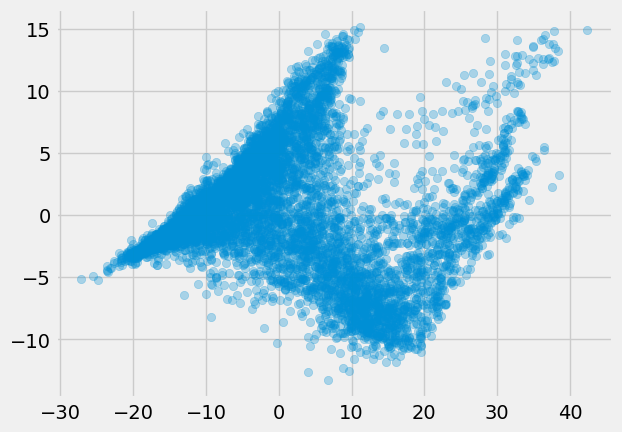

In [40]:
# sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', alpha=0.3, s=10)
# plt.gcf().set_size_inches([12, 11])
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.3)

### 4.2 Embedding with T-SNE

In the previous plot we can't necessarily see the different clusters identified by the PCA analysis. This is in part because of the linear nature of PCA.
T-SNE is another dimensionality reduction technique, however it is non-linear. This allows us to further separated data that may not be separable by a straight line.
To further improve the results of T-SNE we can feed it only the first 10 principal components returned by the PCA analysis, as they explained more than 99% of the variance in the dataset.

In [30]:
tsne = TSNE(
    n_components=2, random_state=0,  perplexity=80, learning_rate='auto', n_iter=2000,
    n_jobs=-1, early_exaggeration=24,
)
tsne2d = tsne.fit_transform(pcs[:, :10])

In [31]:
df_tsne2d = pd.DataFrame(tsne2d, index=pid, columns=['x', 'y'])

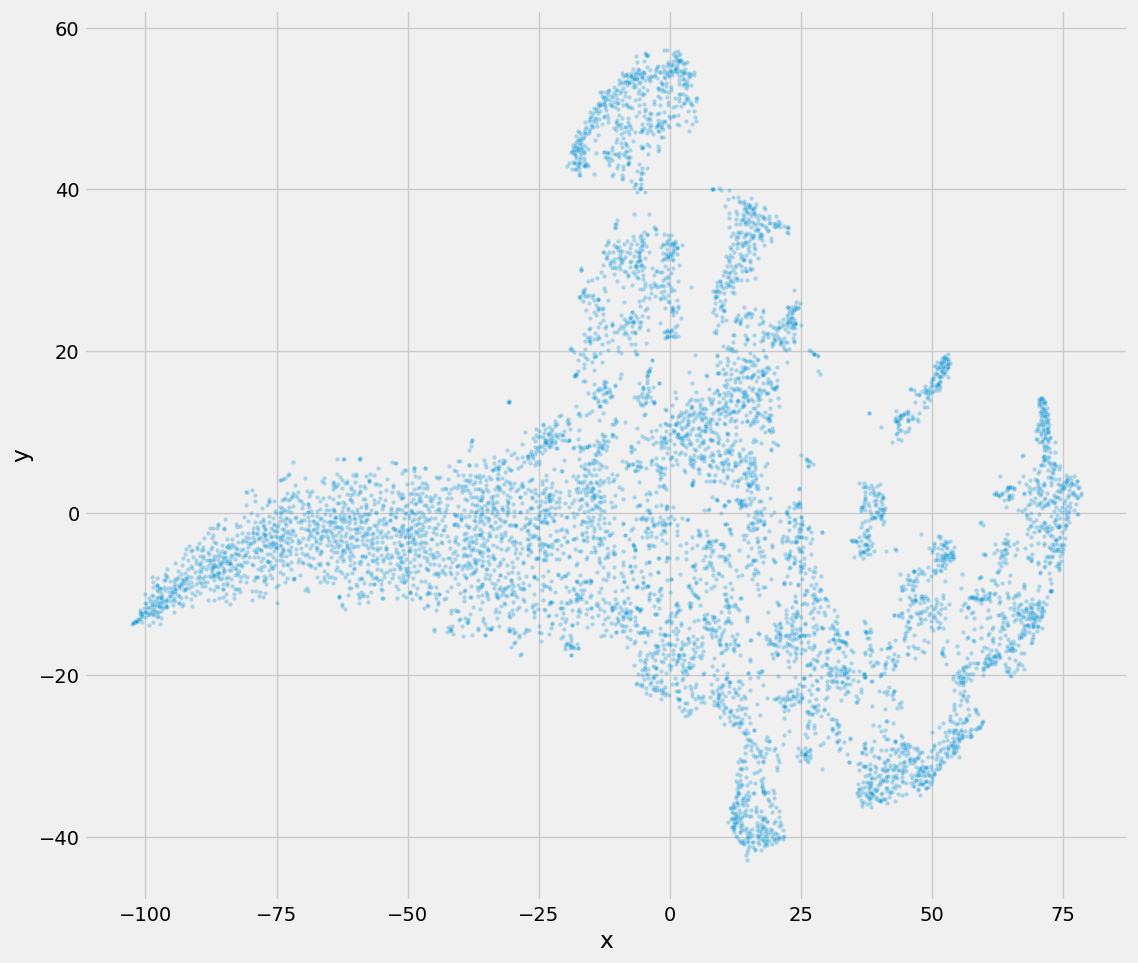

In [32]:
sns.scatterplot(data=df_tsne2d, x='x', y='y', alpha=0.3, s=10)
plt.gcf().set_size_inches([12, 11])

We can now see some clusters pop up a bit more clearly within the 2 dimensional plot above.

## 5. Cluster Analysis with HDBSCAN

HDBSCAN is a hierarchical clustering algorithm, that extracts it's clusters based in the stability of clusters.
This algorithm will help us recognize the cluster patterns from the data points returned by the T-SNE algorithm.


***Note: The follow code's parameters have been tuned and optimized for this use case. We highly recommend you try different parameter settings to optimize the algorithm for your use case.***
***For more information on HDBSCAN follow this link: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html***

In [38]:
hdbscan = HDBSCAN(
    min_cluster_size=200,
    min_samples=10,
    max_cluster_size=1000,
    cluster_selection_epsilon=.0,
    cluster_selection_method='leaf',
)
hdbscan.fit(df_tsne2d.values)

n_class = len(np.unique(hdbscan.labels_))
print('Number of clusters:', n_class)

Number of clusters: 15


In [41]:
hdbscan.labels_

array([ 5, -1,  2, ...,  8, -1,  9])

### 5.1 Create labels for each cluster

The HDBSCAN algorithm returns cluster labels as codes (i.e. -1, 0, 1, 2, 3, ...).
However, we'd like to name our clusters to something more meaningful.
To do this we define the `convert_to_class_name()` which converts the codes into class names (i.e.Class 1, Class 2, and Class 3, etc).
Samples with a label code of -1 mean they are not assigned to any cluster, and they will have a class name of "No Label".


In [42]:
def convert_to_class_name(class_codes: np.ndarray) -> list:
    """This function converts label codes to class names.

    Args:
        class_codes: np.ndarray
            1 dimensional array containing
            the labels of each cluster.

    Returns:
        class_names: list
            A list of Class Names
            for each cluster.

    """
    class_names = ['Class {:02d}'.format(i + 1) for i in class_codes]
    class_names = ['No Label' if item == 'Class 00' else item for item in class_names]
    return class_names

In [45]:
# df_lab = pd.DataFrame(index=df_tsne2d.index)
# df_lab['label'] = convert_to_class_name(hdbscan.labels_)
# df_lab['label'] = df_lab.sort_values('label')

In [47]:
df_pt = df_tsne2d.copy()
df_pt['label'] = convert_to_class_name(hdbscan.labels_)
df_pt = df_pt.sort_values('label')

### 5.2 Plot clusters in 2 dimensional space

<Axes: xlabel='x', ylabel='y'>

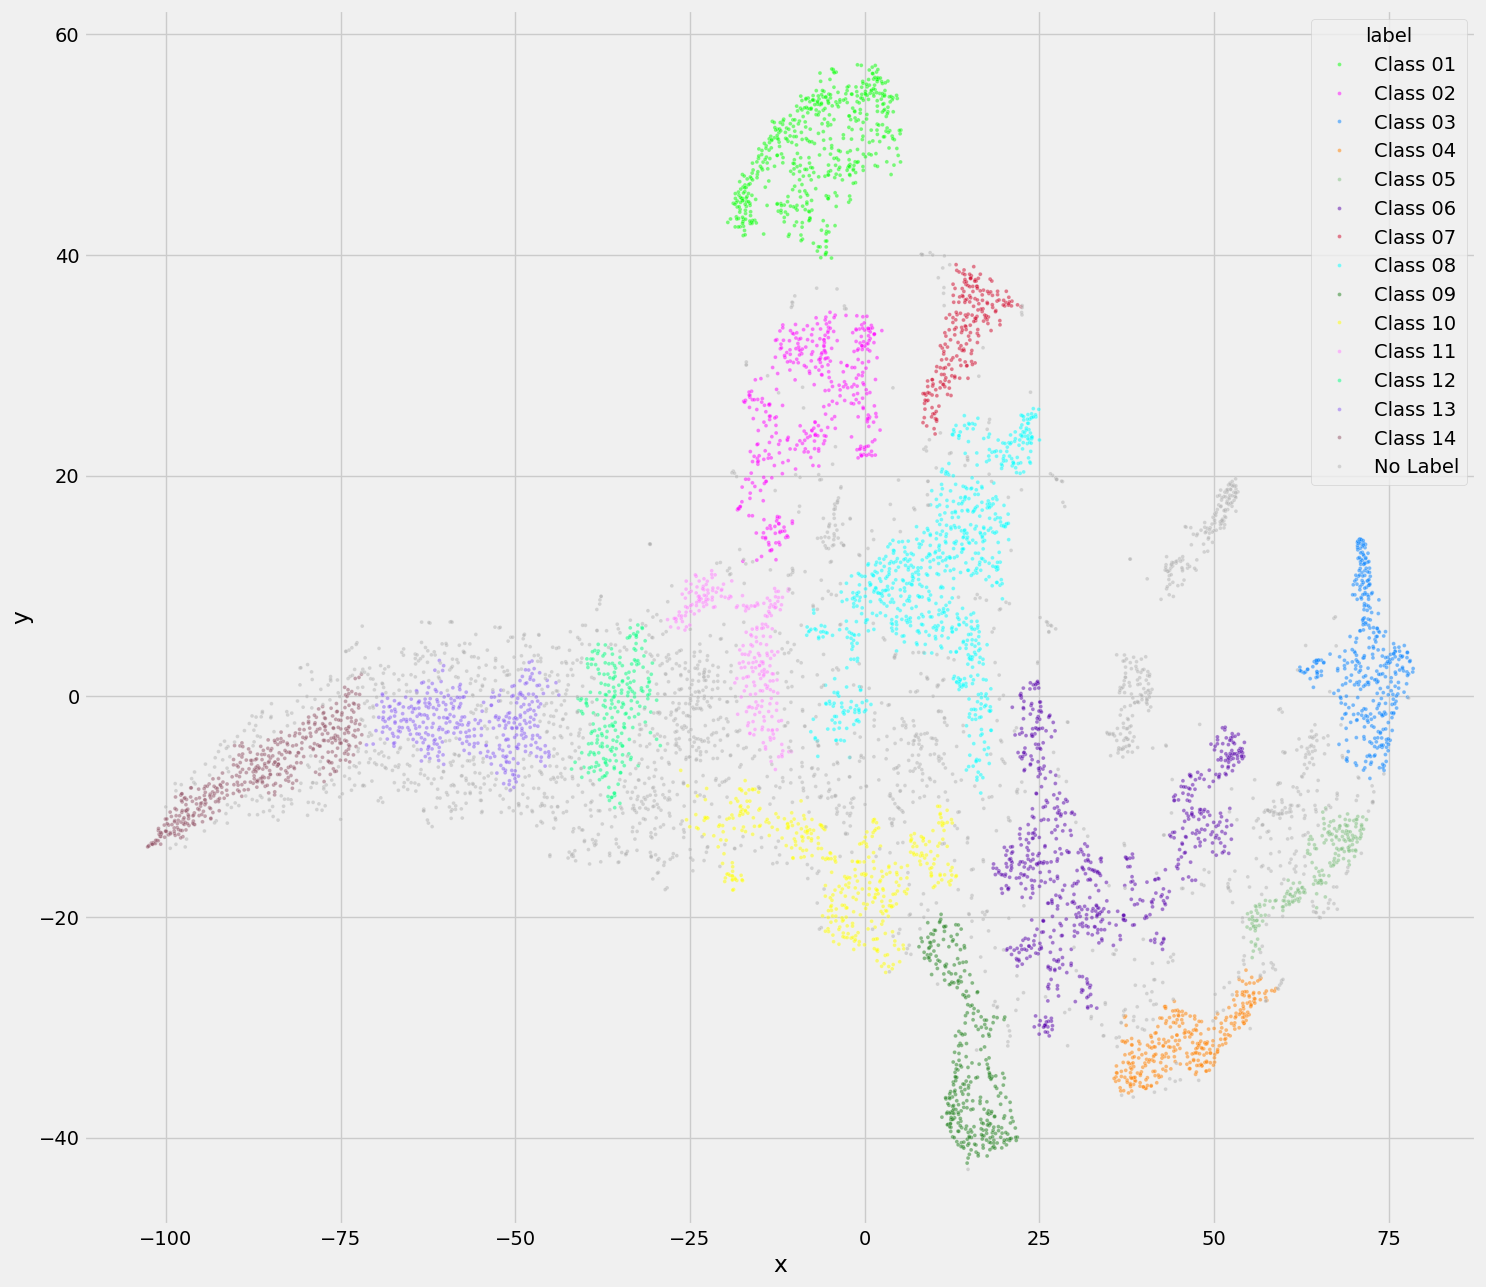

In [48]:
colors = distinctipy.get_colors(n_class - 1) + [(0.7, 0.7, 0.7)]

fig, ax = plt.subplots(figsize=[16, 15])
sns.scatterplot(
    data=df_pt, x='x', y='y', hue='label',
    alpha=0.5, s=8, palette=colors, ax = ax,
)

### 5.3 Visualize time series of each cluster

Now that we have all our clusters identified. We want to see their defining time series, so that we can start to determine what each cluster's typology translates to on the ground. To do so we'll begin by plotting our time series, and relating them to the cluster class names. This is done by making the timeseries' index the names of the clusters we selected.

In [51]:
df_ts = df_vh.copy()
df_ts.index = convert_to_class_name(hdbscan.labels_)
df_ts = df_ts.sort_index()
df_ts.index.name = 'Label'

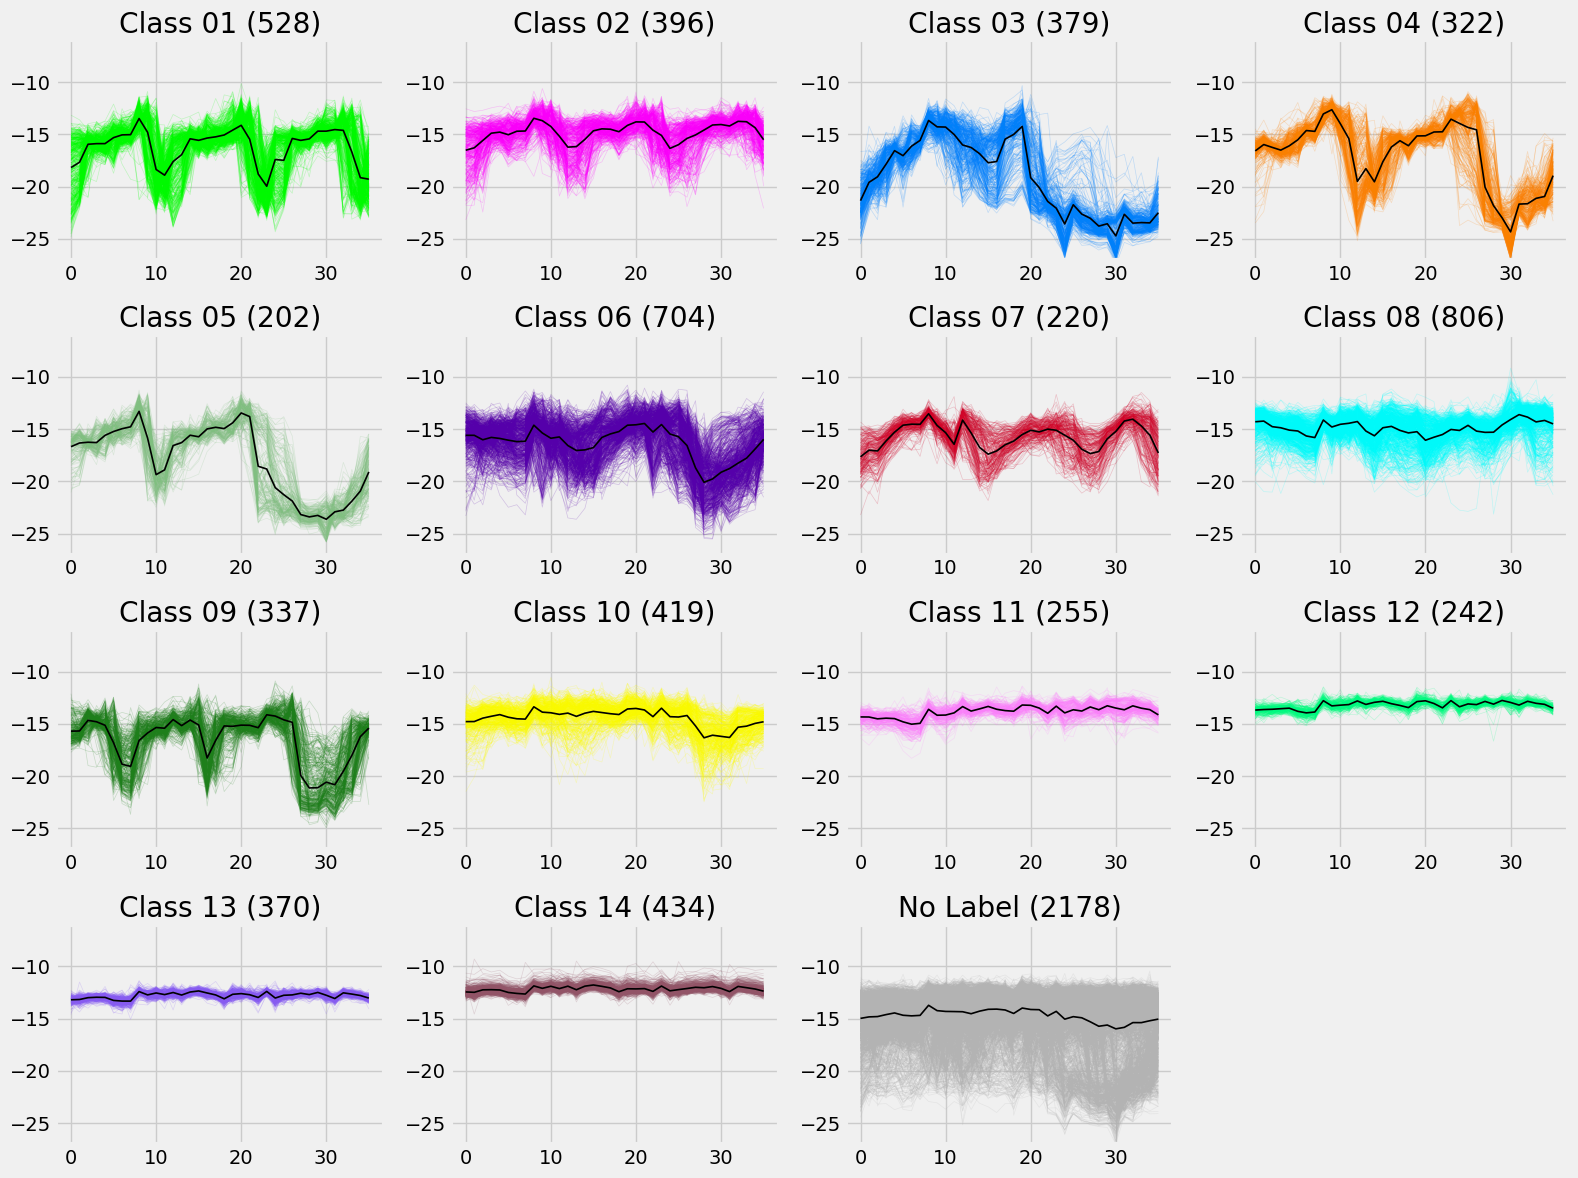

In [52]:
labels = df_ts.index.unique().values

ncol=4
nrow = int(n_class / ncol) + 1

fig = plt.Figure(figsize=[ncol * 4, nrow * 3])
gs = plt.GridSpec(nrow, ncol)

for i in range(n_class):

    target_label = labels[i]

    ts = df_ts.loc[target_label].values
    ts_avg = np.mean(ts, axis=0)

    ax = fig.add_subplot(gs[i])
    ax.plot(ts.T, color=colors[i], alpha=0.2, lw=0.5)
    ax.plot(ts_avg, color='k', lw=1.2)
    ax.set_title(target_label + ' ({})'.format(ts.shape[0]))
    ax.set_ylim([-27, -6])

fig.tight_layout()
fig

## 6. Extracting the average time series for each cluster

As you can see we've also plotted the average time series for each cluster. We can use that information for our dynamic time-warping!
Our logical next step is therefore to extract that value and save it. As we don't really care about the 'No Label' class
we'll make sure to drop it.

In [53]:
df_ref = df_ts.groupby('Label').mean()
df_ref.drop('No Label', inplace=True)
df_ref

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
Label,,,,,,,,,,,,,,,,,,,,,
Class 01,-18.167505,-17.665088,-15.940798,-15.880876,-15.879071,-15.306742,-15.043400,-15.021234,-13.479561,-14.794433,...,-15.384817,-15.568050,-15.429077,-14.686049,-14.686013,-14.535746,-14.612706,-16.679690,-19.135610,-19.280642
Class 02,-16.510677,-16.281925,-15.580901,-14.882354,-14.778631,-15.028120,-14.694705,-14.672647,-13.456012,-13.684339,...,-15.379922,-15.049956,-14.579824,-14.098238,-14.053124,-14.191400,-13.747708,-13.786075,-14.353850,-15.505582
Class 03,-21.335976,-19.583010,-19.051799,-17.849362,-16.552271,-17.031038,-16.122376,-15.570751,-13.664241,-14.274189,...,-22.618271,-23.020332,-23.768003,-23.545325,-24.705038,-22.634178,-23.484018,-23.431120,-23.460851,-22.484857
Class 04,-16.576541,-15.967179,-16.240384,-16.500965,-16.088276,-15.512504,-14.626774,-14.707565,-13.040805,-12.634924,...,-14.557236,-20.039802,-21.811956,-22.968714,-24.321719,-21.662823,-21.629274,-21.112743,-20.934146,-18.940444
Class 05,-16.672699,-16.322943,-16.249290,-16.282242,-15.589054,-15.222954,-14.955154,-14.771749,-13.294078,-15.855035,...,-21.870892,-23.165770,-23.392769,-23.248109,-23.616187,-22.906722,-22.739272,-21.888960,-20.918309,-19.087530
Class 06,-15.586042,-15.587356,-16.014099,-15.786576,-15.886769,-16.052053,-16.191707,-16.149833,-14.618626,-15.366344,...,-16.566216,-18.696794,-20.079535,-19.759453,-19.123015,-18.766994,-18.248597,-17.769088,-16.898667,-15.976739
Class 07,-17.639956,-17.009980,-17.085284,-16.132798,-15.290109,-14.618310,-14.522033,-14.536264,-13.523123,-14.642124,...,-16.918070,-17.333254,-17.136564,-15.914065,-15.216407,-14.221401,-14.046714,-14.689937,-15.569826,-17.277527
Class 08,-14.290590,-14.225081,-14.760081,-14.866261,-15.091544,-15.173213,-15.651073,-15.800697,-14.123697,-14.792168,...,-15.185803,-15.303592,-15.290011,-14.598949,-14.080586,-13.607433,-13.846542,-14.305365,-14.162147,-14.494523
Class 09,-15.693453,-15.671976,-14.655769,-14.793516,-15.130672,-16.800065,-18.854961,-19.061204,-16.580353,-15.865496,...,-14.848416,-19.933238,-21.123423,-21.101363,-20.570006,-20.815896,-19.529743,-18.014589,-16.211372,-15.399640


### 6.1 Save out reference time series

All that is left to do is to save out the reference time series as a dataframe, for use later on.

In [ ]:
df_ref.to_csv('data/vh_ref_2022.csv')